In [1]:
from matplotlib import  pyplot as plt
%matplotlib inline

In [2]:
#encoding: utf-8
from __future__ import print_function
from utils import init_env
init_env('0')
from config import config as cfg
from models.patch_dense_unet import dense121_unet
from dataset.data import compose_ndcube, decompose_ndimage, fit_ndimage_param
import os
import glob
import numpy as np
from dataset.data import rle_encode
from skimage import morphology as m
import pandas as pd
from skimage.io import imread
from tqdm import tqdm

Using TensorFlow backend.


using data from windows
channel last


In [3]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = m.label(img[0, :, :, :], connectivity=2)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

In [7]:
cfg.patch_shape = (256, 256, 3)
def load_model(weigths_path):
    model = dense121_unet(cfg.patch_shape)
    model.load_weights(weigths_path, skip_mismatch=True, by_name=True)

    return model

In [8]:
from keras import backend as K
K.clear_session()
cfg.task_name = 'dense_unet_patch'
epoch = 3
log_dir = os.path.join(cfg.log_dir, cfg.task_name)
weights_path = os.path.join(log_dir, cfg.weigts_file.format(epoch=epoch))
model = load_model(weights_path)

In [19]:
test_img_paths = glob.glob(os.path.join(cfg.test_dir, '*.jpg'))
test_img = imread(test_img_paths[157]) / 255.0
test_patches = decompose_ndimage(test_img, cfg.patch_shape[:2])
test_patches = np.stack(test_patches, axis=0)
print(test_patches.shape)

pred_prob1 = model.predict(test_patches)

pred_prob2 = model.predict(np.flip(test_patches, axis=1))
pred_prob2 = np.flip(pred_prob2, axis=1)

pred_prob3 = model.predict(np.flip(test_patches, axis=2))
pred_prob3 = np.flip(pred_prob3, axis=2)

test_img4 = np.flip(test_patches, axis=1)
test_img4 = np.flip(test_img4, axis=2)
pred_prob4 = model.predict(test_img4)
pred_prob4 = np.flip(pred_prob4, axis=2)
pred_prob4 = np.flip(pred_prob4, axis=1)

pred_prob = (pred_prob1 + pred_prob2 + pred_prob3 + pred_prob4) / 4

(16, 256, 256, 3)


In [26]:
pred_patches = [patches for patches in pred_prob]
com_pred = compose_ndcube(pred_patches, list(test_img.shape[:2]) + [1])
com_pred.shape

(768, 768, 1)

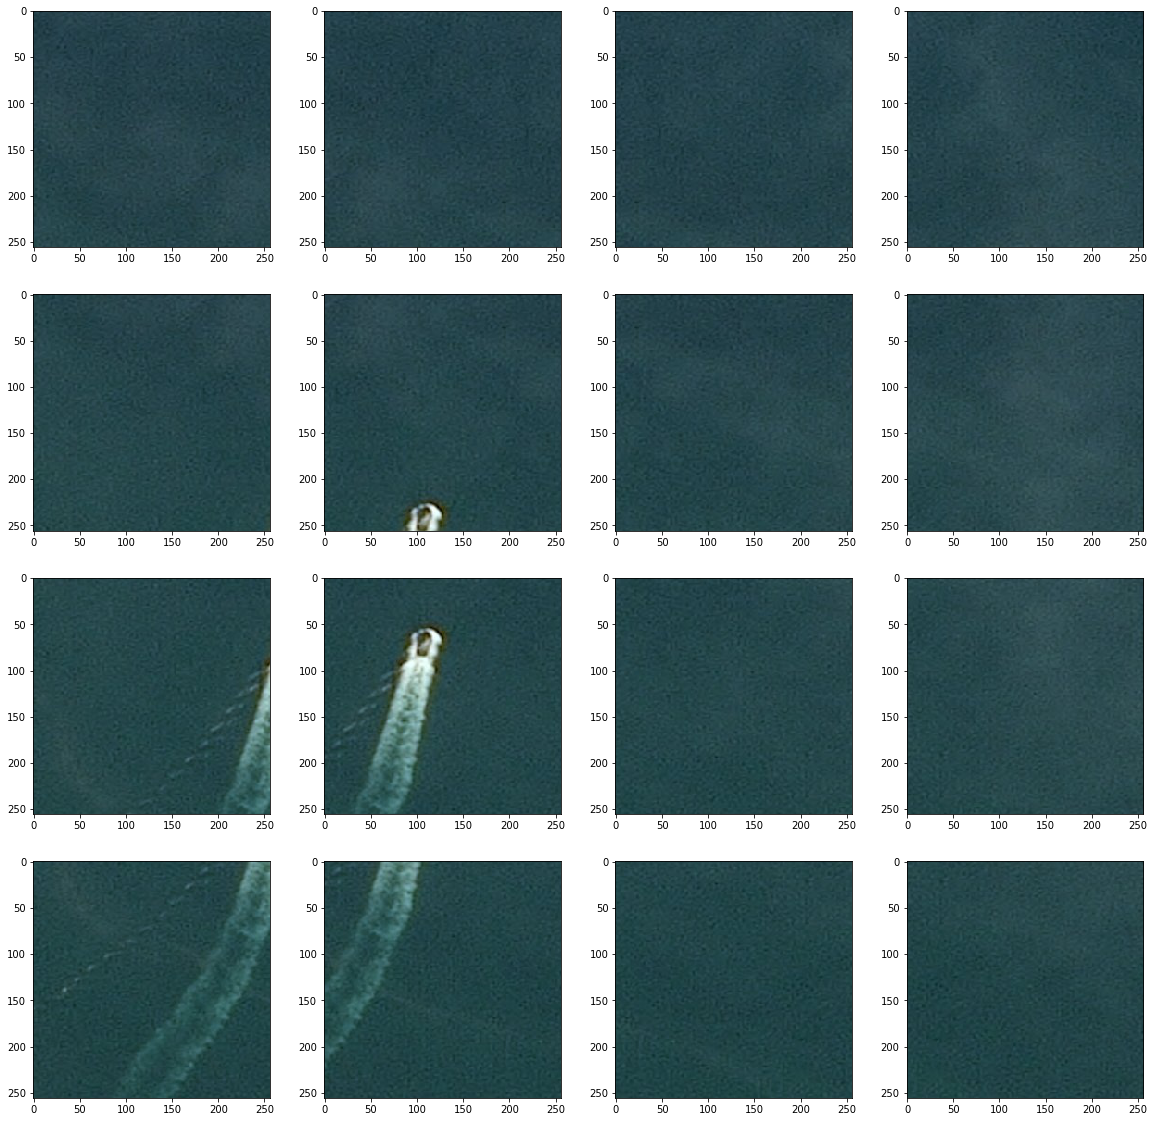

In [21]:
plt.figure(figsize=(20, 20))
flod, _ = fit_ndimage_param(test_img.shape[:2], cfg.patch_shape[:2])
for i in range(flod[0]):
    for j in range(flod[1]):
        index = i*flod[0] + j+1
        s_p = plt.subplot(flod[0], flod[1], i*flod[0] + j+1)
        s_p.imshow(np.squeeze(test_patches[index - 1]))

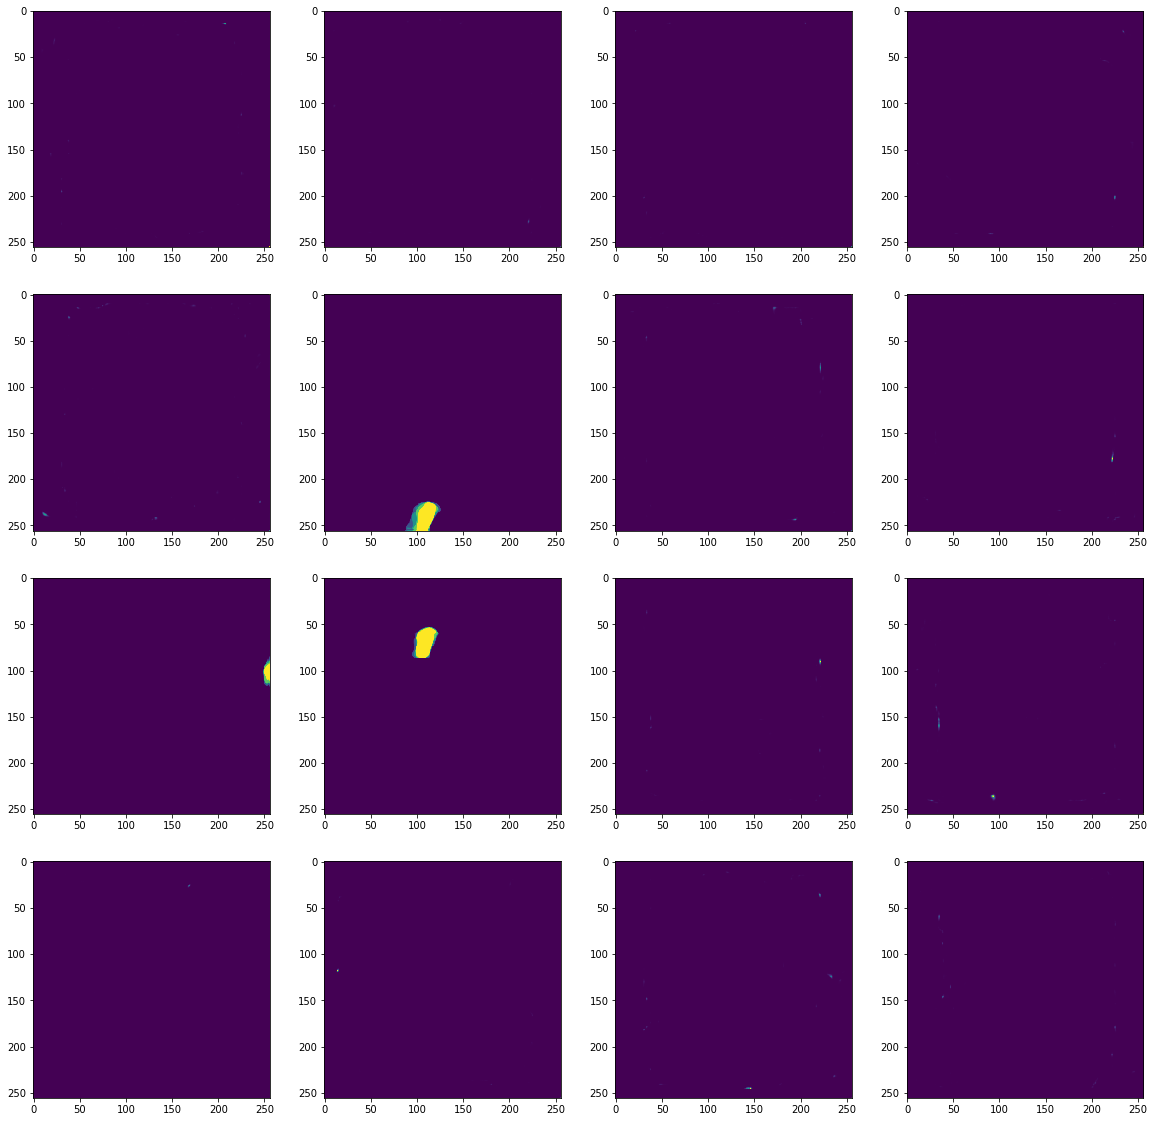

In [22]:
plt.figure(figsize=(20, 20))
flod, _ = fit_ndimage_param(test_img.shape[:2], cfg.patch_shape[:2])
for i in range(flod[0]):
    for j in range(flod[1]):
        index = i*flod[0] + j+1
        s_p = plt.subplot(flod[0], flod[1], i*flod[0] + j+1)
        s_p.imshow(np.squeeze(pred_patches[index - 1]))

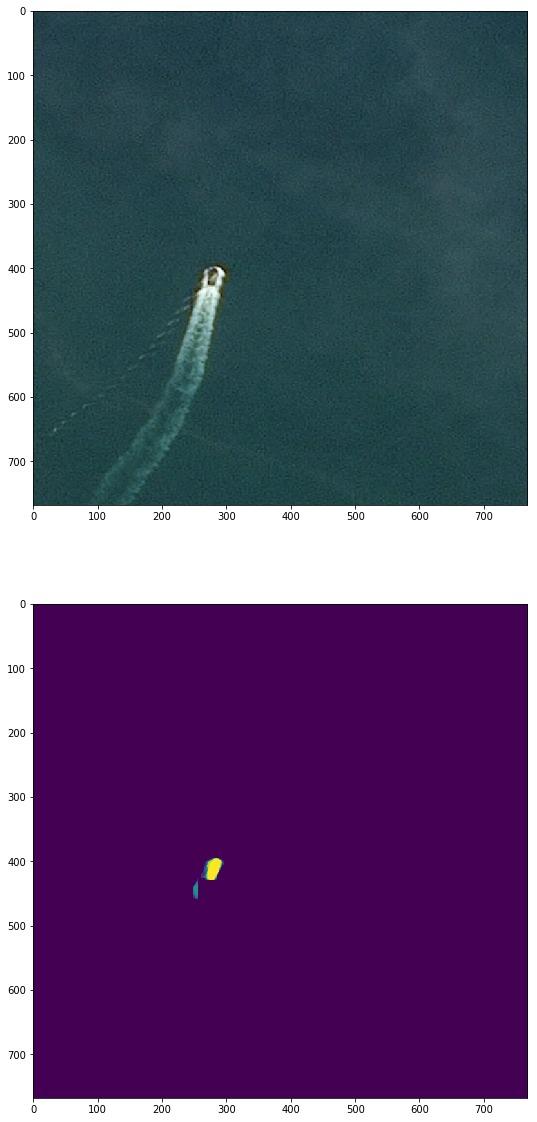

In [24]:
plt.figure(figsize=(40, 20))
plt.subplot(211)
plt.imshow(test_img)
plt.subplot(212)
plt.imshow(np.squeeze(com_pred))

In [61]:
81723 / 64

1276.921875